In [1]:
import os
os.chdir("../")

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, Add
from tensorflow.keras.models import Model
from keras.utils import plot_model
from types import SimpleNamespace
from pathlib import Path
import yaml
from src.image_sharing_plateform.constants import *

from src.image_sharing_plateform.components.data_generator import ImageCaptionGenerator
import pickle
from dataclasses import dataclass

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from PIL import Image
from tensorflow.keras.preprocessing.sequence import pad_sequences

### calculating vocab size:

In [3]:
# file_path = Path(r"U:\nlp_project\Image_Sharing_Plateform\data\processed\training_data.txt")  # Convert to Path object

# with open(file_path, 'r', encoding='utf-8') as file:
#     text = file.read()

# unique_words = []
# caption_lengths = []
# datas = text.split("\n")
# for data in datas:
#     s = data.split("\t")[1]
#     s.split(" ")
#     s1 = s.split(" ")
#     unique_words = unique_words + s1[1:-1]

# print(len(unique_words))
# print(len(set(unique_words)))

### vgg output feature shape:

In [4]:
# with open(r"U:\nlp_project\Image_Sharing_Plateform\data\processed\extracted_features.p", "rb") as file:
#     feature_data = pickle.load(file)

# print(list(feature_data.values())[0].shape)

### calculating max seq length:

In [5]:
file_path = Path(r"U:\nlp_project\Image_Sharing_Plateform\data\processed\training_data.txt")  # Convert to Path object

with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

caption_lengths = []
datas = text.split("\n")
for data in datas:
    s = data.split("\t")[1]
    s1 = s.split(" ")[1:-1]
    caption_lengths.append(len(s1))

In [6]:
max(caption_lengths)

32

In [7]:
# import numpy as np
# # caption_lengths = [len(cap.split()) for caps in train_captions.values() for cap in caps]
# SEQ_LENGTH = int(np.percentile(caption_lengths, 95))  # Choose 95th percentile

In [8]:
# SEQ_LENGTH

In [9]:
# mean_length = np.mean(caption_lengths)
# std_length = np.std(caption_lengths)
# SEQ_LENGTH = int(mean_length + std_length)

In [10]:
# SEQ_LENGTH

In [11]:
def dict_to_namespace(d):
    """Recursively converts a dictionary into a SimpleNamespace object."""
    if isinstance(d, dict):
        return SimpleNamespace(**{k: dict_to_namespace(v) for k, v in d.items()})
    return d

In [12]:
def read_yaml(path_to_yaml: Path):
    try:
        with open(path_to_yaml, "r") as yaml_file:
            content = yaml.safe_load(yaml_file)
            return dict_to_namespace(content)  # Convert dict to namespace
    except FileNotFoundError:
        print(f"File not found: {path_to_yaml}")

In [13]:
import os
def create_directories(path_to_directories: list, verbose=True):
    for path in path_to_directories:
        os.makedirs(path, exist_ok=True)

In [14]:
@dataclass(frozen=True)
class ModelTrainingConfig:
    train_data_path : Path
    validation_data_path : Path
    trained_model_path : Path
    history_path : Path
    CreateSqueezeModel_config: dict
    CreateLSTMSequence_config: dict

In [15]:
class ModelTrainingConfigurationManager:
    def __init__(self,config_filepath):
        
        self.config = read_yaml(config_filepath)
    

    def get_model_training_config(self) -> ModelTrainingConfig:
        model_training_data_config = self.config.model_training

        create_directories([model_training_data_config.trained_model_path, model_training_data_config.history_path])

        model_training_config = ModelTrainingConfig(
            train_data_path = model_training_data_config.train_data_path,

            validation_data_path = model_training_data_config.validation_data_path,
            
            trained_model_path = model_training_data_config.trained_model_path,

            history_path = model_training_data_config.history_path,
            
            CreateSqueezeModel_config = self.config.CreateSqueezeModel_config,

            CreateLSTMSequence_config = self.config.CreateLSTMSequence_config

        )
        
        return model_training_config

In [16]:
# class CreateSqueezeModel(keras.Model):
#     def __init__(self,dropout,activation):
#         super().__init__()
#         """CNN features squeezed from 512 to 256"""
#         self.fe1 = Dropout(dropout)
#         self.fe2 = Dense(256, activation=activation)

#     def call(self, inputs, training=False):
#         x = self.fe1(inputs, training=training)
#         x = self.fe2(x)
#         return x
    
# class CreateLSTMSequence(keras.Model):
#     def __init__(self, vocab_size):
#         super().__init__()
#         """LSTM sequence model"""
#         self.embedding = Embedding(vocab_size, 256, mask_zero=True)
#         self.drp = Dropout(0.5)
#         self.lstm = LSTM(256)

#     def call(self, inputs, training=False):
#         x = self.embedding(inputs)
#         x = self.drp(x, training=training)
#         x = self.lstm(x)
#         return x


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Input, Add
import tensorflow.keras as keras

class CreateSqueezeModel(keras.Model):
    def __init__(self, dropout, activation, **kwargs):
        super().__init__(**kwargs)
        self.fe1 = Dropout(dropout)
        self.fe2 = Dense(256, activation=activation)

    def call(self, inputs, training=False):
        x = self.fe1(inputs, training=training)
        x = self.fe2(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "dropout": self.fe1.rate,
            "activation": self.fe2.activation.__name__,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class CreateLSTMSequence(keras.Model):
    def __init__(self, vocab_size, **kwargs):
        super().__init__(**kwargs)
        self.embedding = Embedding(vocab_size, 256, mask_zero=True)
        self.drp = Dropout(0.5)
        self.lstm = LSTM(256)

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.drp(x, training=training)
        x = self.lstm(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"vocab_size": self.embedding.input_dim})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [18]:

import numpy as np
import tensorflow as tf

class ImageSharingModel:
    def __init__(self, trained_model_path,history_path,CreateSqueezeModel_config, CreateLSTMSequence_config):
        
        """
        Custom Data Generator for Image Captioning using RNN/LSTM.
        """
        self.trained_model_path = trained_model_path
        self.history_path = history_path
        self.CreateSqueezeModel_config = CreateSqueezeModel_config
        self.CreateLSTMSequence_config = CreateLSTMSequence_config
    

    def save_trained_model_history(self,model, history):
        os.makedirs(self.trained_model_path, exist_ok=True)
        
        model.save(os.path.join(self.trained_model_path, "trained_model.h5"))
        
        
        with open(os.path.join(self.history_path, "history.pkl"), "wb") as f:
            pickle.dump(history.history, f)

        # print(f"Model saved at {os.path.join(self.trained_model_path, 'trained_model.h5')}")


    def create_image_captioning_model(self):
        inputs1 = Input(shape=(self.CreateSqueezeModel_config.input_shape,))
        
        squeeze_model = CreateSqueezeModel(self.CreateSqueezeModel_config.dropout,
                                           self.CreateSqueezeModel_config.activation)
        
        fe2 = squeeze_model(inputs1)

        inputs2 = Input(shape=(self.CreateLSTMSequence_config.input_length_lstm,))
        
        lstm_model = CreateLSTMSequence(self.CreateLSTMSequence_config.vocab_size)
        
        se3 = lstm_model(inputs2)

        decoder1 = Add()([fe2, se3])
        decoder2 = Dense(256, activation='relu')(decoder1)
        outputs = Dense(self.CreateLSTMSequence_config.vocab_size, activation='softmax')(decoder2)

        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        model.compile(loss=self.CreateLSTMSequence_config.loss, optimizer=self.CreateLSTMSequence_config.optimizer)

        return model


    def start_model_training(self,model, train_data_generator, validation_data_generator):
        steps_per_epoch = len(train_data_generator)
        validation_steps = len(validation_data_generator)

        # Train the model and store the history

        history = model.fit(
                train_data_generator,
                epochs=1,  # Adjust based on your needs
                steps_per_epoch=steps_per_epoch,
                validation_data=validation_data_generator,
                validation_steps=validation_steps,
                verbose=1
                )

        # self.save_trained_model_history(model, history)

In [19]:
try:
    try:
        manager = ModelTrainingConfigurationManager(PARAMS_FILE_PATH)
        model_training_config = manager.get_model_training_config()
    
        # # # # Access attributes
        train_data_path = model_training_config.train_data_path
        validation_data_path = model_training_config.validation_data_path
        trained_model_path = model_training_config.trained_model_path
        history_path = model_training_config.history_path

        with open(train_data_path + "/" + "train_data.pkl", "rb") as file:
            train_data = pickle.load(file)
            print(train_data.keys())

        with open(validation_data_path + "/" + "validation_data.pkl", "rb") as file:
            validation_data = pickle.load(file)

        train_data_features = train_data["image_data"]
        train_caption_tokenized = train_data["caption_data"]

        validation_data_features = validation_data["image_data"]
        validation_caption_tokenized = validation_data["caption_data"]

    except Exception as e:
        print(f"Error: {e}")
    
    
    train_data_generator = ImageCaptionGenerator(
        image_features = train_data_features , 
        tokenized_captions = train_caption_tokenized, 
        batch_size = 8 , 
        shuffle=True)
    

    validation_data_generator = ImageCaptionGenerator(
        image_features = validation_data_features , 
        tokenized_captions = validation_caption_tokenized , 
        batch_size=10 , 
        shuffle=True)
    

    model_training = ImageSharingModel(
        model_training_config.trained_model_path, 
        model_training_config.history_path,
        model_training_config.CreateSqueezeModel_config, 
        model_training_config.CreateLSTMSequence_config)
    
    
    model = model_training.create_image_captioning_model()
    

    model_training.start_model_training(
        model, 
        train_data_generator, 
        validation_data_generator)

except Exception as e:
        # logger.exception(e)
        raise e

dict_keys(['caption_data', 'image_data', 'feature_data'])
90608
22666
11326/11326 [==============================] - 120s 10ms/step - loss: 3.6566 - val_loss: 3.2389


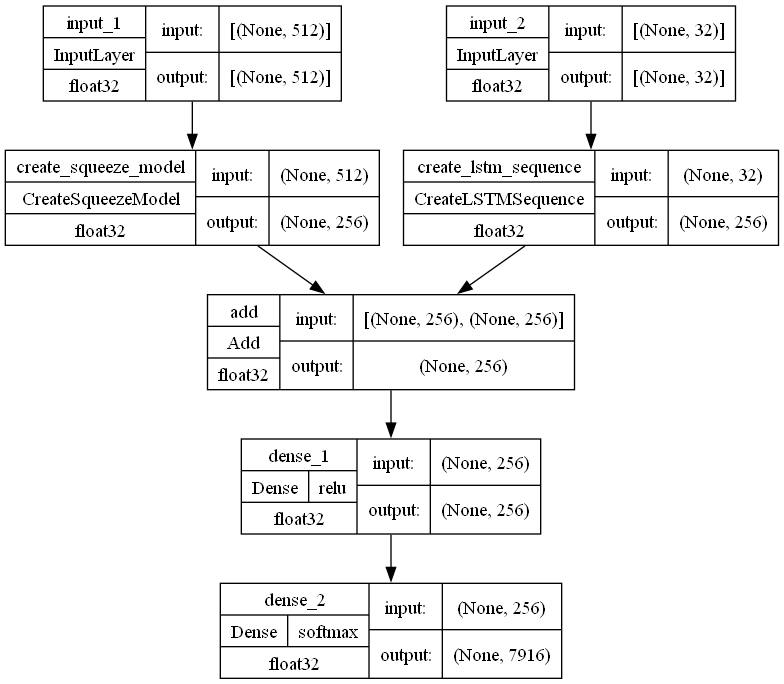

In [20]:
plot_model(model, show_shapes=True,show_dtype=True,show_layer_names=True, show_layer_activations=True, expand_nested=True)

---------------------------- Work in future----------------------------------

#### mlflow code:

In [21]:
import pickle

with open(r"U:\nlp_project\Image_Sharing_Plateform\data\history\history.pkl", "rb") as f:
    history = pickle.load(f)

# Now you can use loaded_history like history.history
print(history.keys())  # Output: dict_keys(['loss', 'val_loss', 'accuracy', 'val_accuracy'])


dict_keys(['loss', 'val_loss'])


In [22]:
history

{'loss': [3.653035879135132], 'val_loss': [3.2335667610168457]}

In [23]:
import mlflow
import os
import tensorflow as tf
import pickle  # To save the history object

# Extract final training and validation loss
final_train_loss = history["loss"][-1]
final_val_loss = history["val_loss"][-1]

# Extract accuracy if available
final_train_acc = history.get("accuracy", [None])[-1]
final_val_acc = history.get("val_accuracy", [None])[-1]

# Log parameters, metrics, and artifacts in MLflow
with mlflow.start_run():
    mlflow.log_param("epochs", 10)
    mlflow.log_metric("train_loss", final_train_loss)
    mlflow.log_metric("val_loss", final_val_loss)

    if final_train_acc is not None:
        mlflow.log_metric("train_accuracy", final_train_acc)
    if final_val_acc is not None:
        mlflow.log_metric("val_accuracy", final_val_acc)

    # Log artifacts (history and model)
    mlflow.log_artifact(r"U:\nlp_project\Image_Sharing_Plateform\data\history\history.pkl")
    mlflow.log_artifact(r"U:\nlp_project\Image_Sharing_Plateform\data\trained_model\cnn_lstm_model\trained_model.h5")

print("Training metrics and history saved. Run `mlflow ui` to view logs.")

Training metrics and history saved. Run `mlflow ui` to view logs.


In [ ]:
# try:
#     # Ensure model_training_config is assigned before use
#     manager = ModelTrainingConfigurationManager(PARAMS_FILE_PATH)
#     model_training_config = manager.get_model_training_config()

#     train_data_path = model_training_config.train_data_path
#     validation_data_path = model_training_config.validation_data_path
#     trained_model_path = model_training_config.trained_model_path
#     history_path = model_training_config.history_path

#     try:
#         with open(train_data_path + "/" + "train_data.pkl", "rb") as file:
#             train_data = pickle.load(file)

#         with open(validation_data_path + "/" + "validation_data.pkl", "rb") as file:
#             validation_data = pickle.load(file)

#         train_data_features = train_data["image_data"]
#         train_caption_tokenized = train_data["caption_data"]

#         validation_data_features = validation_data["image_data"]
#         validation_caption_tokenized = validation_data["caption_data"]

#     except Exception as e:
#         raise RuntimeError(f"Error while loading dataset: {e}")

#     train_data_generator = ImageCaptionGenerator(
#         image_features=train_data_features,
#         tokenized_captions=train_caption_tokenized,
#         batch_size=8,
#         shuffle=True
#     )

#     validation_data_generator = ImageCaptionGenerator(
#         image_features=validation_data_features,
#         tokenized_captions=validation_caption_tokenized,
#         batch_size=10,
#         shuffle=True
#     )

#     model_training = ModelTraining(
#         model_training_config.trained_model_path, 
#         model_training_config.CreateSqueezeModel_config, 
#         model_training_config.CreateLSTMSequence_config
#     )

#     model = model_training.create_image_captioning_model()

#     model_training.start_model_training(
#         model, 
#         train_data_generator, 
#         validation_data_generator
#     )

# except Exception as e:
#     print(f"Error: {e}")
#     raise e  # Rethrow the error for debugging


In [ ]:
# steps_per_epoch = len(train_data_generator)
# validation_steps = len(validation_data_generator)

# # Train the model and store the history
# history = model.fit(
#     train_data_generator,
#     epochs=10,  # Adjust based on your needs
#     steps_per_epoch=steps_per_epoch,
#     validation_data=validation_data_generator,
#     validation_steps=validation_steps,
#     verbose=1
# )

In [ ]:
# batch_size = 10
# epoch = 10
# if batch_size is 10, and total data in 90608 then in each each there will be 9060 batch
# if epoch ==10 then 9060 batch in each batch i.e whole data will do to training 10 times in 9060 batch and each batch contains 10 datapoints 

In [ ]:
# for batch in train_data_generator:
#     (X1_batch, X2_batch), y_batch = batch
#     print(f"X1_batch shape: {X1_batch.shape}")  # Should be (batch_size, 256)
#     print(f"X2_batch shape: {X2_batch.shape}")  # Should be (batch_size, 32)
#     print(f"y_batch shape: {y_batch.shape}")    # Should be (batch_size,)
#     break